In [5]:
import pandas as pd
import numpy as np
from ast import literal_eval
with open("007_results.jsonl", "r") as f:
    contents = f.readlines()
    contents = [literal_eval(i) for i in contents]

df = pd.DataFrame(data=contents)
df = df[df.eval_split.str.contains("test")]
df = df[df.macroF1 > 0.5]
df.tail(2)

,macroF1,y_true,y_pred,train_split,eval_split,model_name
278,0.624183,"[Negative, Neutral, Negative, Neutral, Negativ...","[Neutral, Neutral, Neutral, Positive, Neutral,...",train,test_BiH,classla/bcms-bertic
280,0.785185,"[Negative, Neutral, Negative, Neutral, Negativ...","[Negative, Neutral, Neutral, Positive, Negativ...",train,test_BiH,classla/bcms-bertic


In [6]:
from typing import Iterable
def macroF1_stats(i: Iterable[float]) -> str:
    return f"{np.mean(i):0.4f} ± {np.std(i):0.4f}"

df.groupby(["model_name", "train_split", "eval_split"]).agg(
    {
        "macroF1": lambda i: [round(i, 2) for i in i],
        "macroF1": macroF1_stats
    }

)

macroF1
model_name                 train_split eval_split                 
EMBEDDIA/crosloengual-bert train       test        0.7709 ± 0.0113
                                       test_HR     0.7987 ± 0.0138
                                       test_SRB    0.7280 ± 0.0219
                           train_HR    test_HR     0.7748 ± 0.0174
                                       test_SRB    0.7146 ± 0.0175
                           train_SRB   test_HR     0.7762 ± 0.0114
                                       test_SRB    0.6989 ± 0.0275
classla/bcms-bertic        train       test        0.7941 ± 0.0101
                                       test_BiH    0.7578 ± 0.0679
                                       test_HR     0.8260 ± 0.0186
                                       test_SRB    0.7385 ± 0.0170
                           train_HR    test_HR     0.8147 ± 0.0083
                                       test_SRB    0.7249 ± 0.0105
                           train_SRB   test_HR     0.7953 ± 0.0207
                                       test_SRB    0.7130 ± 0.0278
xlm-roberta-base           train       test        0.7184 ± 0.0139
                                       test_HR     0.7700 ± 0.0090
                                       test_SRB    0.6428 ± 0.0279
                           train_HR    test_HR     0.7296 ± 0.0251
                                       test_SRB    0.6128 ± 0.0341
                           train_SRB   test_HR     0.7323 ± 0.0282
                                       test_SRB    0.6487 ± 0.0203

In [7]:
import numpy as np

C_trained_on_train = df.train_split == "train"
C_evaled_on_test = df.eval_split == "test"
from typing import Iterable


def macroF1_stats(i: Iterable[float]) -> str:
    return f"{np.mean(i):0.4f} ± {np.std(i):0.4f}"


gb = df[C_trained_on_train & C_evaled_on_test].groupby(
    "model_name".split()
).agg(
    [macroF1_stats,
     #len
     ]
).rename(columns={"len": "sample size"}).sort_values(
    by=("macroF1", "macroF1_stats"), ascending=False
)
print(gb.to_latex())
gb

\begin{tabular}{ll}
\toprule
{} &          macroF1 \\
{} &    macroF1\_stats \\
model\_name                 &                  \\
\midrule
classla/bcms-bertic        &  0.7941 ± 0.0101 \\
EMBEDDIA/crosloengual-bert &  0.7709 ± 0.0113 \\
xlm-roberta-base           &  0.7184 ± 0.0139 \\
\bottomrule
\end{tabular}



/home/rupnik/anaconda3/lib/python3.9/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


,macroF1
,macroF1_stats
model_name,
classla/bcms-bertic,0.7941 ± 0.0101
EMBEDDIA/crosloengual-bert,0.7709 ± 0.0113
xlm-roberta-base,0.7184 ± 0.0139


## Is bertic better than cse bert?

In [8]:
from scipy.stats import mannwhitneyu

C_model_bertic = df.model_name == "classla/bcms-bertic"
C_model_csebert = df.model_name == "EMBEDDIA/crosloengual-bert"

bertic = df[C_trained_on_train & C_evaled_on_test & C_model_bertic].macroF1     
csebert = df[C_trained_on_train & C_evaled_on_test & C_model_csebert].macroF1   


mannwhitneyu(bertic, csebert, alternative="greater").pvalue


0.0034965034965034965

In [9]:
from pint import UnitRegistry
u = UnitRegistry()

<Figure size 288x288 with 0 Axes>

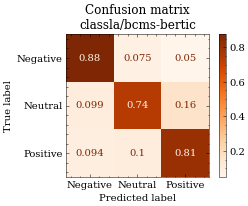

<Figure size 288x288 with 0 Axes>

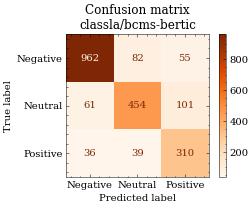

In [10]:
C_model_bertic = df.model_name == "classla/bcms-bertic"

subset = df[C_trained_on_train & C_evaled_on_test & C_model_bertic
]
import numpy as np
y_true = np.array([np.array(i) for i in subset.y_true]).reshape(-1)
y_pred = np.array([np.array(i) for i in subset.y_pred]).reshape(-1)

import matplotlib.pyplot as plt
plt.style.use("science no-latex".split())
plt.figure(figsize=(4,4))
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred, cmap="Oranges", labels=["Negative", "Neutral", "Positive"],
   normalize="true"
   )

plt.title(f"Confusion matrix\nclassla/bcms-bertic")
plt.savefig("images/007_bertic_cm_normalized_true.png")
plt.savefig("images/007_bertic_cm_normalized_true.pdf")

plt.show()

import matplotlib.pyplot as plt
plt.style.use("science no-latex".split())
plt.figure(figsize=(4,4))
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred, cmap="Oranges", labels=["Negative", "Neutral", "Positive"],
   # normalize="true"
   )

plt.title(f"Confusion matrix\nclassla/bcms-bertic")
plt.savefig("images/007_bertic_cm_normalized_none.png")
plt.savefig("images/007_bertic_cm_normalized_none.pdf")

plt.show()

In [11]:
subset

,macroF1,y_true,y_pred,train_split,eval_split,model_name
6,0.800865,"[Negative, Neutral, Negative, Negative, Neutra...","[Negative, Neutral, Neutral, Negative, Neutral...",train,test,classla/bcms-bertic
24,0.781375,"[Negative, Neutral, Negative, Negative, Neutra...","[Negative, Neutral, Negative, Negative, Neutra...",train,test,classla/bcms-bertic
42,0.776619,"[Negative, Neutral, Negative, Negative, Neutra...","[Negative, Neutral, Negative, Negative, Neutra...",train,test,classla/bcms-bertic
60,0.805243,"[Negative, Neutral, Negative, Negative, Neutra...","[Negative, Neutral, Neutral, Negative, Neutral...",train,test,classla/bcms-bertic
78,0.802067,"[Negative, Neutral, Negative, Negative, Neutra...","[Negative, Neutral, Neutral, Negative, Neutral...",train,test,classla/bcms-bertic
96,0.797154,"[Negative, Neutral, Negative, Negative, Neutra...","[Negative, Neutral, Neutral, Negative, Neutral...",train,test,classla/bcms-bertic
114,0.795617,"[Negative, Neutral, Negative, Negative, Neutra...","[Negative, Neutral, Negative, Negative, Neutra...",train,test,classla/bcms-bertic


In [12]:
df.groupby(["model_name", "train_split", "eval_split"]).agg(
    [macroF1_stats, len]
)#.sort_values(by=("macroF1","macroF1_stats"), ascending=False)

/home/rupnik/anaconda3/lib/python3.9/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


macroF1    
                                                     macroF1_stats len
model_name                 train_split eval_split                     
EMBEDDIA/crosloengual-bert train       test        0.7709 ± 0.0113   7
                                       test_HR     0.7987 ± 0.0138   7
                                       test_SRB    0.7280 ± 0.0219   7
                           train_HR    test_HR     0.7748 ± 0.0174   6
                                       test_SRB    0.7146 ± 0.0175   6
                           train_SRB   test_HR     0.7762 ± 0.0114   6
                                       test_SRB    0.6989 ± 0.0275   6
classla/bcms-bertic        train       test        0.7941 ± 0.0101   7
                                       test_BiH    0.7578 ± 0.0679   6
                                       test_HR     0.8260 ± 0.0186   7
                                       test_SRB    0.7385 ± 0.0170   7
                           train_HR    test_HR     0.8147 ± 0.0083   6
                                       test_SRB    0.7249 ± 0.0105   6
                           train_SRB   test_HR     0.7953 ± 0.0207   6
                                       test_SRB    0.7130 ± 0.0278   6
xlm-roberta-base           train       test        0.7184 ± 0.0139   6
                                       test_HR     0.7700 ± 0.0090   6
                                       test_SRB    0.6428 ± 0.0279   6
                           train_HR    test_HR     0.7296 ± 0.0251   5
                                       test_SRB    0.6128 ± 0.0341   5
                           train_SRB   test_HR     0.7323 ± 0.0282   4
                                       test_SRB    0.6487 ± 0.0203   4

# Inspecting individual models' performance on cross-parliament data

In [13]:
from IPython.display import display

for model_name in df.model_name.unique():
    print("Model:", model_name)
    C_model = df.model_name == model_name
    C_train_on_fulltrain = df.train_split == "train"
    C_test_on_full_test = df.eval_split == "test"
    gb = df[C_model & (~C_train_on_fulltrain) & (~ C_test_on_full_test)].groupby(["train_split", "eval_split"]).agg(
    macroF1_stats)
    display(gb)

Model: xlm-roberta-base


/tmp/ipykernel_3804643/2016291241.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  gb = df[C_model & (~C_train_on_fulltrain) & (~ C_test_on_full_test)].groupby(["train_split", "eval_split"]).agg(


macroF1
train_split eval_split                 
train_HR    test_HR     0.7296 ± 0.0251
            test_SRB    0.6128 ± 0.0341
train_SRB   test_HR     0.7323 ± 0.0282
            test_SRB    0.6487 ± 0.0203

Model: classla/bcms-bertic


/tmp/ipykernel_3804643/2016291241.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  gb = df[C_model & (~C_train_on_fulltrain) & (~ C_test_on_full_test)].groupby(["train_split", "eval_split"]).agg(


macroF1
train_split eval_split                 
train_HR    test_HR     0.8147 ± 0.0083
            test_SRB    0.7249 ± 0.0105
train_SRB   test_HR     0.7953 ± 0.0207
            test_SRB    0.7130 ± 0.0278

Model: EMBEDDIA/crosloengual-bert


/tmp/ipykernel_3804643/2016291241.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  gb = df[C_model & (~C_train_on_fulltrain) & (~ C_test_on_full_test)].groupby(["train_split", "eval_split"]).agg(


macroF1
train_split eval_split                 
train_HR    test_HR     0.7748 ± 0.0174
            test_SRB    0.7146 ± 0.0175
train_SRB   test_HR     0.7762 ± 0.0114
            test_SRB    0.6989 ± 0.0275

In [14]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])
from sklearn.metrics import ConfusionMatrixDisplay

for model in ["EMBEDDIA/crosloengual-bert", "classla/bcms-bertic"]:
    for train in ["train_HR", "train_SRB"]:
        for test in [
            # "dev_HR", 
            # "dev_SRB", 
            "test_HR", 
            "test_SRB"
            ]:
            C_model = df.model_name==model
            C_train = df.train_split == train
            C_test = df.eval_split == test
            subset = df[C_model & C_train & C_test]
            y_true = []
            y_pred = []
            for i in subset.y_true.values:
                y_true.extend(i)
            for i in subset.y_pred.values:
                y_pred.extend(i)
            fig, ax = plt.subplots(figsize=(6,6))
            ConfusionMatrixDisplay.from_predictions(
            y_true, y_pred, cmap="Oranges", labels=["Negative", "Neutral", "Positive"],
            ax = ax,
            normalize="true"
            )
            plt.title(f"{model}\ntrain on: {train},\ntest on: {test}")
            plt.savefig(f"images/CMs/007_{model.replace('/', '_')}_{train=}_{test=}.png")
            plt.savefig(f"images/CMs/007_{model.replace('/', '_')}_{train=}_{test=}.pdf")
            plt.show()